## Project 2
#### В данном проекте мы проверяем несколько гипотез касаемо закономерностей процесса прохождения игры для пользователей различных групп:
##### По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
##### Кажется, повторное прохождение обучения положительно влияет на оплату, верно?
##### Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

### Проверяемые гипотезы:
1. Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение?
2. Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь?
3. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? (Насколько прозрачен процесс взаимодействия с игрой?)

#### Подготовка данных:

Загружаем данные:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline
events_df = pd.read_csv('7_4_Events.csv')
purchase_df = pd.read_csv('purchase.csv')

Создаем фильтр по времени регистрации пользователей (только 2018 г.):

In [2]:
cond = (events_df.event_type == 'registration')&(events_df.start_time>='2018-01-01')&(events_df.start_time<'2019-01-01')

Фильтруем events_df по фильтру пользователей 2018 г.:

In [3]:
registered = events_df[cond].user_id.to_list()
events = events_df[events_df.user_id.isin(registered)]

Соединяем events_df и purchase_df:

In [4]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={'id': 'event_id'})
purchase_df = purchase_df.rename(columns={'id': 'purchase_id'})
events_dfs = pd.concat([events_df, purchase_df], sort  = False)

Сортируем events_df по хронологии событий и приводим столбцы с отметками времени к временному формату:

In [5]:
total_events_df = events_dfs[events_dfs['user_id'].isin(registered)]
total_events_df = total_events_df.reset_index(drop = True).sort_values('start_time')
total_events_df.start_time = pd.to_datetime(total_events_df.start_time, format = '%Y-%m-%dT%H:%M:%S') #Приводим время событий к временному формату
total_events_df.event_datetime = pd.to_datetime(total_events_df.event_datetime, format = '%Y-%m-%dT%H:%M:%S')

### Гипотеза 1: Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение?

Выделяем время прохождения различных этапов среди всех пользователей. Не берем в расчет периоды времени обучения, так как наша задача заключается в сравнении времени прохождения различных этапов среди тех, кто прошел обучение и тех, кто не прошел обучение, а это значит, что сравнивать время внутри обучения бессмысленно:

In [6]:
registration_time = total_events_df[total_events_df['event_type']=='registration'][['user_id', 'start_time']].rename(columns = {'start_time':'registration_time'})
tutorial_time = total_events_df[total_events_df['event_type']=='tutorial_start'][['user_id', 'start_time']].rename(columns = {'start_time':'tutorial_start_time'})
tutorial_time_wo_duplicates = tutorial_time.drop_duplicates('user_id')
level_choice_time = total_events_df[total_events_df['event_type']=='level_choice'][['user_id', 'start_time']].rename(columns = {'start_time':'level_choice_time'})
pack_choice_time = total_events_df[total_events_df['event_type']=='pack_choice'][['user_id', 'start_time']].rename(columns = {'start_time':'pack_choice_time'})
purchase_time = total_events_df[total_events_df['event_type']=='purchase'][['user_id', 'event_datetime']].rename(columns = {'event_datetime':'purchase_time'})

tutorial_delta = registration_time.merge(tutorial_time_wo_duplicates, on='user_id', how='inner')
level_choice_after_tutorial_delta = tutorial_time_wo_duplicates.merge(level_choice_time, on='user_id', how='inner')
level_choice_delta = registration_time.merge(level_choice_time, on='user_id', how='inner')
pack_choice_delta = level_choice_time.merge(pack_choice_time, on='user_id', how='inner')
purchase_delta = pack_choice_time.merge(purchase_time, on='user_id', how='inner')
purchase_reg_delta = registration_time.merge(purchase_time, on='user_id', how='inner')

tutorial_delta['tutorial_delta'] = tutorial_delta['tutorial_start_time'] - tutorial_delta['registration_time']
level_choice_after_tutorial_delta['level_choice_at_delta'] = level_choice_after_tutorial_delta['level_choice_time'] - level_choice_after_tutorial_delta['tutorial_start_time']
level_choice_delta['level_choice_delta'] = level_choice_delta['level_choice_time'] - level_choice_delta['registration_time']
pack_choice_delta['pack_choice_delta'] = pack_choice_delta['pack_choice_time'] - pack_choice_delta['level_choice_time']
purchase_delta['purchase_delta'] = purchase_delta['purchase_time'] - purchase_delta['pack_choice_time']
purchase_reg_delta['purchase_reg_delta'] = purchase_reg_delta['purchase_time'] - purchase_reg_delta['registration_time']

Соединяем все датафреймы в единый:

In [7]:
all_delta = registration_time[['user_id', 'registration_time']].merge(tutorial_delta[['user_id', 'tutorial_delta']], on='user_id', how='left')
all_delta = all_delta.merge(level_choice_delta[['user_id', 'level_choice_delta']], on='user_id', how='left')
all_delta = all_delta.merge(pack_choice_delta[['user_id', 'pack_choice_delta']], on='user_id', how='left')
all_delta = all_delta.merge(purchase_delta[['user_id', 'purchase_delta']], on='user_id', how='left')
all_delta = all_delta.merge(purchase_reg_delta[['user_id', 'purchase_reg_delta']], on='user_id', how='left')

Выделяем 2 датафрейма с пользователями, прошедшими обучения и пользователями, не начинавшими обучение:

In [8]:
users_with_tutorial_finished = total_events_df[total_events_df['event_type']=='tutorial_finish']['user_id']
uwtf = all_delta[all_delta['user_id'].isin(users_with_tutorial_finished)]

users_with_tutorial_start = total_events_df[total_events_df['event_type']=='tutorial_start']['user_id']
all_users = total_events_df['user_id'].unique()
users_without_tutorial = set(all_users).difference(set(users_with_tutorial_start))
uwot = all_delta[all_delta['user_id'].isin(users_without_tutorial)]

Cчитаем среди прошедших обучение пользователей среднее время прохождения различных этапов:

In [9]:
print('''Среднее время прохождения различных этапов среди пользователей, прошедших обучение:
От регистрации до выбора уровня сложности:{};
От выбора уровня сложности до выбора пакета вопросов:{};
От выбора пакета вопросов до первой оплаты:{};
От регистрации до первой оплаты: {}'''\
      .format(uwtf['level_choice_delta'].mean(), uwtf['pack_choice_delta'].mean(),\
              uwtf['purchase_delta'].mean(), uwtf['purchase_reg_delta'].mean()))

Среднее время прохождения различных этапов среди пользователей, прошедших обучение:
От регистрации до выбора уровня сложности:0 days 07:05:36.854819;
От выбора уровня сложности до выбора пакета вопросов:0 days 00:05:18.146058;
От выбора пакета вопросов до первой оплаты:3 days 17:17:59.641326;
От регистрации до первой оплаты: 4 days 00:30:03.247408


In [10]:
uwtf['level_choice_delta'].mean() - uwot['level_choice_delta'].mean() 

Timedelta('0 days 01:50:03.732370')

Cчитаем среди НЕ прошедших обучение пользователей среднее время прохождения различных этапов:

In [11]:
print('''Среднее время прохождения различных этапов среди пользователей, НЕ прошедших обучение:
От регистрации до выбора уровня сложности:{};
От выбора уровня сложности до выбора пакета вопросов:{};
От выбора пакета вопросов до первой оплаты:{};
От регистрации до первой оплаты: {}'''\
      .format(uwot['level_choice_delta'].mean(), uwot['pack_choice_delta'].mean(),\
              uwot['purchase_delta'].mean(), uwot['purchase_reg_delta'].mean()))

Среднее время прохождения различных этапов среди пользователей, НЕ прошедших обучение:
От регистрации до выбора уровня сложности:0 days 05:15:33.122448;
От выбора уровня сложности до выбора пакета вопросов:0 days 00:05:23.824324;
От выбора пакета вопросов до первой оплаты:4 days 04:49:33.590909;
От регистрации до первой оплаты: 4 days 09:06:01.909090


Далее берем средние значение по каждому этапу для пользователей, прошедших обучение и не начинавших обучение, создаем новый столбец с отметкой о прохождении обучения и соединяем в единый датафрейм:

In [12]:
uwtf_mean = uwtf.mean()
uwot_mean = uwot.mean()
uwtf['user_type'] = 'with_finished_training'
uwot['user_type'] = 'without_training'
uw = uwtf.append(uwot)

<ipython-input-12-84232af4a0b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uwtf['user_type'] = 'with_finished_training'
<ipython-input-12-84232af4a0b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uwot['user_type'] = 'without_training'


Переводим столбцы со временем выполнения каждого этапа в числовой тип (int) для возможности построения графиков:

In [13]:
uw.tutorial_delta = pd.to_timedelta(uw.tutorial_delta)/pd.to_timedelta('1 hour')
uw.level_choice_delta = pd.to_timedelta(uw.level_choice_delta)/pd.to_timedelta('1 hour')
uw.pack_choice_delta = pd.to_timedelta(uw.pack_choice_delta)/pd.to_timedelta('1 hour')
uw.purchase_delta = pd.to_timedelta(uw.purchase_delta)/pd.to_timedelta('1 hour')
uw.purchase_reg_delta = pd.to_timedelta(uw.purchase_reg_delta)/pd.to_timedelta('1 hour')

Строим графики о прохождении каждого этапа среди пользователей, прошедших обучение и не начинавших обучение:

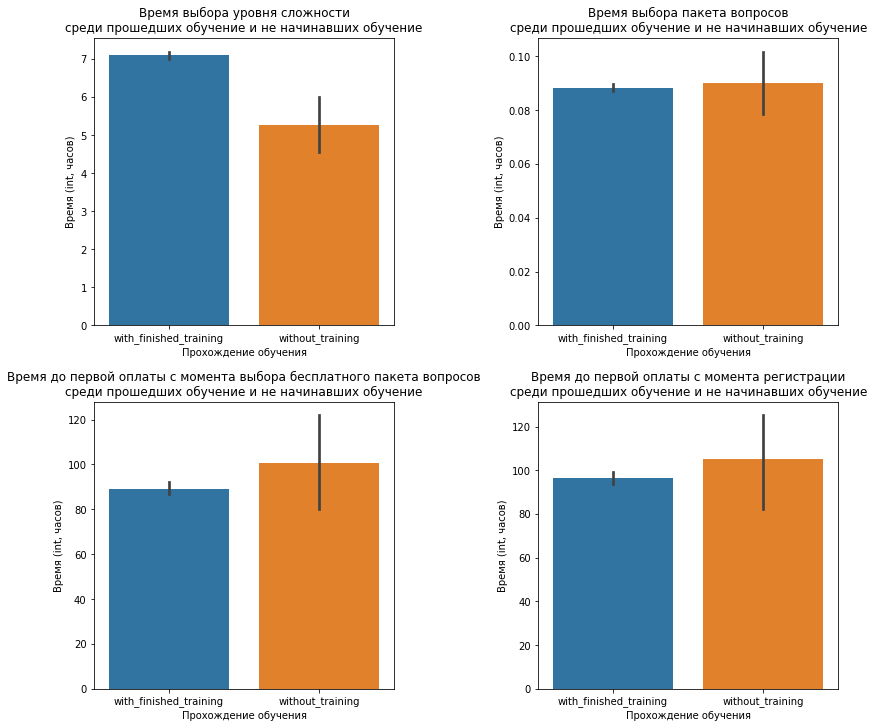

In [14]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
abar = sns.barplot(x='user_type', y='level_choice_delta', data=uw, ax=ax1)
bbar= sns.barplot(x='user_type', y='pack_choice_delta', data=uw, ax=ax2)
cbar = sns.barplot(x='user_type', y='purchase_delta', data=uw, ax=ax3)
dbar = sns.barplot(x='user_type', y='purchase_reg_delta', data=uw, ax=ax4)
abar.set(title='''Время выбора уровня сложности
среди прошедших обучение и не начинавших обучение''', xlabel='Прохождение обучения', ylabel='Время (int, часов)')
bbar.set(title='''Время выбора пакета вопросов
среди прошедших обучение и не начинавших обучение''', xlabel='Прохождение обучения', ylabel='Время (int, часов)')
cbar.set(title='''Время до первой оплаты с момента выбора бесплатного пакета вопросов
среди прошедших обучение и не начинавших обучение''', xlabel='Прохождение обучения', ylabel='Время (int, часов)')
dbar.set(title='''Время до первой оплаты с момента регистрации
среди прошедших обучение и не начинавших обучение''', xlabel='Прохождение обучения', ylabel='Время (int, часов)')
plt.show()

- Как мы видим, прохождение обучения в игре влияет на время до первой покупки: пользователи, прошедшие обучение, быстрее совершают первую покупку как с момента выбора бесплатного пакета вопросов (в среднем на 11:31:33 быстрее), так и с момента регистрации (в среднем на 08:35:58 быстрее), чем пользователи, не проходившие обучение. Однако, пользователи, не проходившие обучение, значительно быстрее доходят до выбора сложности (в среднем на 01:50:03 быстрее). И это понятно - если пользователь только зарегистрировался и хочет начать пользоваться приложением, но не хочет тратить время на обучение, то он сразу выполнит первый обязательный этап - выбор уровня сложности, в то время, как пользователи, прошедшие обучение, уже провели какое-то время в игре и, возможно, им нужно передохнуть или выполнить свои другие дела перед тем, как выбрать уровень сложности.

### Гипотеза 2: Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь?

Создаем датафрейм с пользователями, начинавшими обучение и подсчитываем количество попыток:

In [15]:
users_with_tutorial_start = total_events_df[total_events_df['event_type']=='tutorial_start']
attempts_df = users_with_tutorial_start.groupby(['user_id'])[['event_type']].count()
attempts_df.columns = ['tutorial_attempts']
attempts_df.reset_index(inplace = True)

Создаем датафрейм с оплатами (из датафрейма с фильтром по 2018 г.) и соединяем его с датафреймом из предыдущего шага.
Далее в получившийся датафрейм добавляем столбец с конверсией оплаты пользователей и строим график:

[Text(0, 0.5, 'Конверсия (%)'),
 Text(0.5, 0, 'Количество попыток обучения'),
 Text(0.5, 1.0, 'Зависимость вероятности оплаты от количества попыток обучения')]

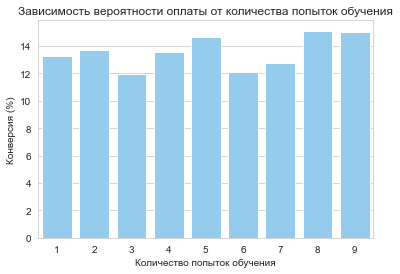

In [16]:
purchased_users_df = total_events_df[total_events_df['event_type']=='purchase'][['user_id', 'purchase_id', 'amount']]
attempts_purchases=purchased_users_df.merge(attempts_df, on='user_id', how='right')
count_of_tutorial = attempts_purchases.groupby(['tutorial_attempts']).agg({'user_id':'count', 'purchase_id':'count', 'amount':'sum'})
count_of_tutorial['conversion'] = 100 * count_of_tutorial['purchase_id'] / count_of_tutorial['user_id']
count_of_tutorial = count_of_tutorial.reset_index()
sns.set_style('whitegrid')
ax = sns.barplot(x='tutorial_attempts', y='conversion', data=count_of_tutorial, color='lightskyblue')
ax.set(title='Зависимость вероятности оплаты от количества попыток обучения', xlabel='Количество попыток обучения', ylabel='Конверсия (%)')

##### Как видно из графика, конверсия покупок не имеет зависимости от количества попыток обучения (не смотря на планомерное повышение конверсии среди пользователей, которые начинали обучение в диапазонах от 3 до 5 раз и от 6 до 8 раз), из чего мы можем сделать вывод, что наша гипотеза "Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал пользователь" не подтвердилась.

Создаем датафрейм с пользователями, окончившими обучение и подсчитываем количество окончаний:

In [17]:
users_with_tutorial_finish = total_events_df[total_events_df['event_type']=='tutorial_finish']
count_of_finish_df = users_with_tutorial_finish.groupby(['user_id'])[['event_type']].count()
count_of_finish_df.columns = ['count_of_finish']
count_of_finish_df.reset_index(inplace = True)

Используем датафрейм с оплатами (из датафрейма с фильтром по 2018 г.) и соединяем его с датафреймом из предыдущего шага.
Далее в получившийся датафрейм добавляем столбец с конверсией оплаты пользователей:

[Text(0, 0.5, 'Конверсия (%)'),
 Text(0.5, 0, 'Количество завершенных обучений'),
 Text(0.5, 1.0, 'Зависимость вероятности оплаты от количества завершений обучения')]

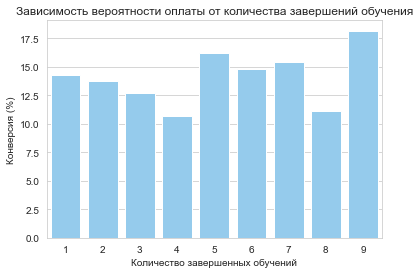

In [18]:
finish_purchases=purchased_users_df.merge(count_of_finish_df, on='user_id', how='right')
count_of_finish = finish_purchases.groupby(['count_of_finish']).agg({'user_id':'count', 'purchase_id':'count', 'amount':'sum'})
count_of_finish['conversion'] = 100 * count_of_finish['purchase_id'] / count_of_finish['user_id']
count_of_finish = count_of_finish.reset_index()
sns.set_style('whitegrid')
bx = sns.barplot(x='count_of_finish', y='conversion', data=count_of_finish, color='lightskyblue')
bx.set(title='Зависимость вероятности оплаты от количества завершений обучения', xlabel='Количество завершенных обучений', ylabel='Конверсия (%)')

##### Как видно из графика, конверсия покупок не имеет зависимости от количества завершений обучения, из чего мы можем сделать вывод, что наша гипотеза "Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые завершал пользователь" не подтвердилась.

### Гипотеза 3: Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

Создаем датафрейм со списком времени начала обучения и выбора уровня сложности пользователей (на основе датафрейма из 1-й гипотезы) и из него создаем отдельный датафрейм с условием, что время начала обучения больше (позже) времени выбора уровня сложности:

In [19]:
tutorial_after_level_choice_df = tutorial_time.merge(level_choice_time, on='user_id', how='inner')
tutorial_after_level_choice = tutorial_after_level_choice_df[tutorial_after_level_choice_df['tutorial_start_time'] \
                                                             > tutorial_after_level_choice_df['level_choice_time']]

Считаем общее количество пользователей и тех, кто начал обучение после выбора уровня сложности: 

In [20]:
a = tutorial_after_level_choice_df['user_id'].count()
b = tutorial_after_level_choice['user_id'].count()
c = tutorial_after_level_choice['user_id'].count() / tutorial_after_level_choice_df['user_id'].count()
print('''Из всех пользователей, выбравших уровень сложности ({}), {} начали обучение после выбора уровня сложности, что составляет {:.2%}'''\
      .format(a, b, c))

Из всех пользователей, выбравших уровень сложности (12686), 2792 начали обучение после выбора уровня сложности, что составляет 22.01%


##### Ответ на нашу гипотезу "Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? (Насколько прозрачен процесс взаимодействия с игрой?)" - 22.01% пользователей не понимают процесса взаимодействия с игрой и обращаются к обучению. Это довольно большая часть аудитории и стоит либо что-то изменить во взаимодействии пользователей с игрой, либо сделать хотя-бы часть обучения обязательным этапом.